In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

E0000 00:00:1728503888.184997    2316 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:479
D1009 19:58:08.237210058    2316 config.cc:196]                        gRPC EXPERIMENT call_status_override_on_cancellation   OFF (default:OFF)
D1009 19:58:08.237229641    2316 config.cc:196]                        gRPC EXPERIMENT call_v3                                OFF (default:OFF)
D1009 19:58:08.237233023    2316 config.cc:196]                        gRPC EXPERIMENT canary_client_privacy                  ON  (default:ON)
D1009 19:58:08.237235444    2316 config.cc:196]                        gRPC EXPERIMENT capture_base_context                   ON  (default:ON)
D1009 19:58:08.237237779    2316 config.cc:196]                        gRPC EXPERIMENT client_idleness                        ON  (defau

In [2]:
#with strategy.scope():
# Load the dataset
data = np.load('/kaggle/input/1024age5/AGE_1024_512_Class5.npz') #/home/showv/BanglaOCR/Dataset
X_train, y_train = data['X_train'], data['y_train']
X_test, y_test = data['X_test'], data['y_test']

# Reshape the images (from flat to original size)
X_train = X_train.reshape((-1, 512, 1024, 1))  # Grayscale
X_test = X_test.reshape((-1, 512, 1024, 1))
    
# Convert grayscale to 3 channels by repeating the single channel
X_train = np.repeat(X_train, 3, axis=-1)
X_test = np.repeat(X_test, 3, axis=-1)

# Normalize pixel values (0-255) to range (0-1)
X_train = X_train / 255.0
X_test = X_test / 255.0

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (9154, 512, 1024, 3)
y_train shape: (9154, 5)
X_test shape: (2289, 512, 1024, 3)
y_test shape: (2289, 5)


In [ ]:
!echo $CUDA_VISIBLE_DEVICES
!export CUDA_VISIBLE_DEVICES=0,1


# Check if GPU is available
print(tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [3]:
import tensorflow as tf

# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

# instantiate a distribution strategy
#tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

# Create a strategy for distributed training
#strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1728504052.454025    2316 service.cc:145] XLA service 0x56df14a0b1d0 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728504052.454101    2316 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1728504052.454106    2316 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1728504052.454109    2316 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1728504052.454114    2316 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1728504052.454117    2316 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1728504052.454120    2316 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1728504052.454123    2316 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1728504052.454125    2316 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

In [4]:
#with strategy.scope():
with tpu_strategy.scope():
    # Define the base model with ImageNet weights, without the top layers
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(512, 1024, 3))

    # Freeze the base model layers
    base_model.trainable = False

    # Add custom layers on top of the base model
    inputs = Input(shape=(512, 1024, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)  # Global average pooling layer
    x = Dense(128, activation='relu')(x)  # Custom dense layer
    outputs = Dense(5, activation='softmax')(x)  # Output layer for 2 classes

    # Create the final model
    model = Model(inputs, outputs)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
model.summary()

I0000 00:00:1728504246.446701    2316 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 512, 1024, 3)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 16, 32, 512)    │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,997 (56.39 MB)

 Trainable params: 66,309 (259.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [5]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
#checkpoint = ModelCheckpoint('model_checkpoint.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=False)

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=100,  # You can increase epochs based on performance
                    batch_size=16,
                    callbacks=[early_stopping])

# Save the model in .keras format
model.save('AP-VGG16_Model_1024Age_Trained.keras')

Epoch 1/100


2024-10-09 20:09:06.637040: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1728504547.254323    3133 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(cf2aa43b2628eb11:0:0), session_name()


  2/573 ━━━━━━━━━━━━━━━━━━━━ 1:10 124ms/step - accuracy: 0.0000e+00 - loss: 2.0869 

I0000 00:00:1728504555.722785    3133 tpu_compile_op_common.cc:245] Compilation of cf2aa43b2628eb11:0:0 with session name  took 8.466980303s and succeeded
I0000 00:00:1728504555.733574    3133 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(cf2aa43b2628eb11:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_1084135364236099689", property.function_library_fingerprint = 10335854955523778076, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,512,1024,3,;2,5,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728504555.733617    3133 tpu_compilation_cache_interface.cc:541] After adding entry for key 

573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.2150 - loss: 1.6185

2024-10-09 20:10:50.108572: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add/ReadVariableOp.
I0000 00:00:1728504650.452553    3057 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(90dbabecd4e2bbc9:0:0), session_name()
I0000 00:00:1728504657.640524    3057 tpu_compile_op_common.cc:245] Compilation of 90dbabecd4e2bbc9:0:0 with session name  took 7.187891143s and succeeded
I0000 00:00:1728504657.643294    3057 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(90dbabecd4e2bbc9:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_1653014779253563726", property.function_library_fingerprint = 13737692027588376877, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, t

573/573 ━━━━━━━━━━━━━━━━━━━━ 122s 195ms/step - accuracy: 0.2151 - loss: 1.6184 - val_accuracy: 0.3798 - val_loss: 1.5357
Epoch 2/100
573/573 ━━━━━━━━━━━━━━━━━━━━ 54s 93ms/step - accuracy: 0.3418 - loss: 1.5245 - val_accuracy: 0.3763 - val_loss: 1.4864
Epoch 3/100
573/573 ━━━━━━━━━━━━━━━━━━━━ 54s 93ms/step - accuracy: 0.3572 - loss: 1.4967 - val_accuracy: 0.4286 - val_loss: 1.4456
Epoch 4/100
573/573 ━━━━━━━━━━━━━━━━━━━━ 54s 93ms/step - accuracy: 0.3456 - loss: 1.4596 - val_accuracy: 0.4042 - val_loss: 1.4205
Epoch 5/100
573/573 ━━━━━━━━━━━━━━━━━━━━ 54s 93ms/step - accuracy: 0.3551 - loss: 1.4555 - val_accuracy: 0.4425 - val_loss: 1.3964
Epoch 6/100
573/573 ━━━━━━━━━━━━━━━━━━━━ 54s 93ms/step - accuracy: 0.4057 - loss: 1.4180 - val_accuracy: 0.4181 - val_loss: 1.3791
Epoch 7/100
573/573 ━━━━━━━━━━━━━━━━━━━━ 54s 93ms/step - accuracy: 0.4076 - loss: 1.3894 - val_accuracy: 0.4321 - val_loss: 1.3597
Epoch 8/100
573/573 ━━━━━━━━━━━━━━━━━━━━ 54s 94ms/step - accuracy: 0.4582 - loss: 1.3458 - va

ValueError: Device /job:localhost/replica:0/task:0/device:CPU:0 is not found

In [6]:
# Evaluate on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc * 100:.2f}%")

I0000 00:00:1728510841.828743    3097 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(19effd6a51711d80:0:0), session_name()


 1/72 ━━━━━━━━━━━━━━━━━━━━ 11:48 10s/step - accuracy: 0.2500 - loss: 1.3871

I0000 00:00:1728510850.939484    3097 tpu_compile_op_common.cc:245] Compilation of 19effd6a51711d80:0:0 with session name  took 9.110650832s and succeeded
I0000 00:00:1728510850.942497    3097 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(19effd6a51711d80:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_1653014779253563726", property.function_library_fingerprint = 13737692027588376877, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,512,1024,3,;4,5,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728510850.942543    3097 tpu_compilation_cache_interface.cc:541] After adding entry for key 

71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.5048 - loss: 1.2100

I0000 00:00:1728510861.587171    3098 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(b3f0bb447bfe5e4a:0:0), session_name()


72/72 ━━━━━━━━━━━━━━━━━━━━ 26s 222ms/step - accuracy: 0.5060 - loss: 1.2090


I0000 00:00:1728510866.722196    3098 tpu_compile_op_common.cc:245] Compilation of b3f0bb447bfe5e4a:0:0 with session name  took 5.1349615s and succeeded
I0000 00:00:1728510866.724766    3098 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(b3f0bb447bfe5e4a:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_1653014779253563726", property.function_library_fingerprint = 13737692027588376877, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "3,512,1024,3,;3,5,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728510866.724794    3098 tpu_compilation_cache_interface.cc:541] After adding entry for key b3

Test accuracy: 54.70%


In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import tensorflow.keras.optimizers as optimizers
import matplotlib.pyplot as plt

# Get the default learning rate for the Adam optimizer
d_learning_rate = optimizers.Adam().get_config()['learning_rate']

# Predictions
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# Metrics calculation
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Additional information
print("Number of Epochs:", len(history.history['accuracy']))
print("Size of Image:", X_train.shape[1:])
print("Learning Rate: ",d_learning_rate)

2024-10-09 21:55:11.889954: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_1/dense_1/Add/ReadVariableOp.
I0000 00:00:1728510911.966815    3076 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(e42aead185cebef0:0:0), session_name()


 1/72 ━━━━━━━━━━━━━━━━━━━━ 9:51 8s/step

I0000 00:00:1728510918.402112    3076 tpu_compile_op_common.cc:245] Compilation of e42aead185cebef0:0:0 with session name  took 6.435236937s and succeeded
I0000 00:00:1728510918.404126    3076 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(e42aead185cebef0:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_7554328199930506751", property.function_library_fingerprint = 9860039779482514300, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728510918.404156    3076 tpu_compilation_cache_interface.cc:541] After adding entry for key e42aead185ce

71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step

I0000 00:00:1728510944.252867    3126 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(582c592f28d852f2:0:0), session_name()


72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 439ms/step


I0000 00:00:1728510949.572945    3126 tpu_compile_op_common.cc:245] Compilation of 582c592f28d852f2:0:0 with session name  took 5.320036419s and succeeded
I0000 00:00:1728510949.574784    3126 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(582c592f28d852f2:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_7802100377574395766", property.function_library_fingerprint = 7784625329921963681, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "3,512,1024,3,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728510949.574810    3126 tpu_compilation_cache_interface.cc:541] After adding entry for ke

Accuracy: 0.5347313237221494
Precision: 0.5397521490392527
Recall: 0.5382117946905514
F1 Score: 0.5375496323724913
Number of Epochs: 100
Size of Image: (512, 1024, 3)
Learning Rate:  0.0010000000474974513


72/72 ━━━━━━━━━━━━━━━━━━━━ 28s 378ms/step


<Figure size 1600x1600 with 0 Axes>

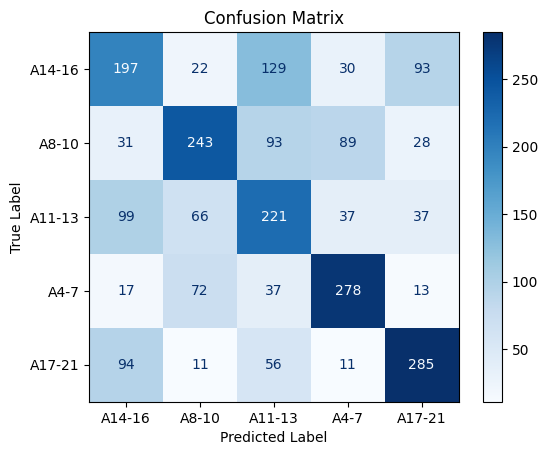

In [8]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Evaluate the model and get predictions
y_pred = model.predict(X_test)

# Convert the predictions from one-hot encoded to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
labels = ['A14-16', 'A8-10', 'A11-13', 'A4-7', 'A17-21']  # Adjust according to your labels

plt.figure(figsize=(16, 16))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Add title and axis labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()

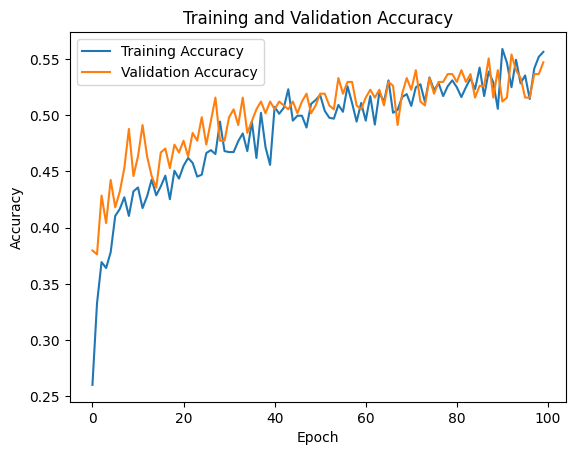

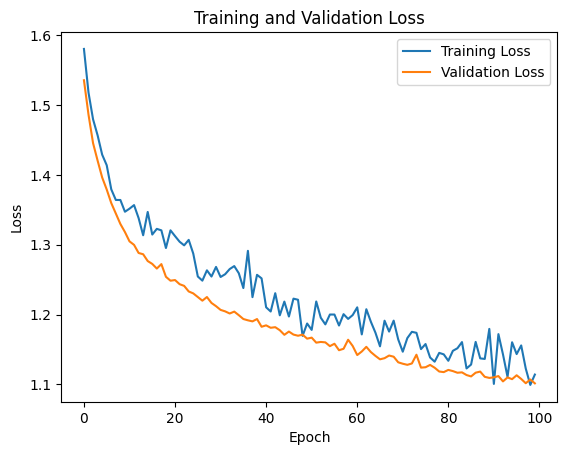

In [9]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()